In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder

# 저장된 딥러닝 모델을 복구하는 함수.
from keras.models import load_model

# epoch마다 모델을 저장하는 함수.
from keras.callbacks import ModelCheckpoint

# 더이상 성능 향상이 이루어지지 않는다면 조기 중단시킬 수 있는 함수.
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold 

import warnings
warnings.filterwarnings('ignore')

# GPU 사용 초기화 및 할당.
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
# Seed 값 설정.
np.random.seed(3)
tf.random.set_seed(3)

# 데이터 읽기.
df = pd.read_csv('data/wine.csv', header=None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,1
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,1


In [3]:
# 데이터 정보 확인.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6497 non-null   float64
 1   1       6497 non-null   float64
 2   2       6497 non-null   float64
 3   3       6497 non-null   float64
 4   4       6497 non-null   float64
 5   5       6497 non-null   float64
 6   6       6497 non-null   float64
 7   7       6497 non-null   float64
 8   8       6497 non-null   float64
 9   9       6497 non-null   float64
 10  10      6497 non-null   float64
 11  11      6497 non-null   int64  
 12  12      6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [4]:
# 결측 재확인.
df.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [5]:
# 데이터 프레임의 일부 발췌.
# 데이터가 너무 많은 경우 학습 속도를 위해 Test로서 일부 샘플만을 가지고 학습을 시켜보는 것도 하나의 방법.
# df = df.sample(n=1000).reset_index(drop=True)

# 특성 데이터와 타겟 데이터로 분할.
x = df.drop(12, axis=1)
y = df[12]
# display(x)
# display(y)

In [6]:
# 모델 설정.
model = Sequential()

# 12개의 노드로 이루어진 입력층과 3개의 은닉층 설정.
model.add(Dense(30, input_dim = 12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))

# 타겟 데이터가 이진형 범주형 변수이므로 활성화 함수로 sigmoid 통과.
model.add(Dense(1, activation='sigmoid'))
    
# 모델 컴파일.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 참고.
# 가장 기본적인 모델 저장 방법.
# model.save('test1.h5') 이용.

# epoch 마다 저장하는 방식으로 전환.
# 저장될 경로와 파일명.
model_path = 'models/{epoch}-{val_loss}.hdf5'

# 기준은 val_loss 외의 var_accrucy를 줘도 되나, 다소의 문제가 있으므로 통상적으로 'val_loss'를 지정.
# 저장 조건1 : 'val_loss'를 기준으로 이전 값들보다 높은 수치는 저장하지 않으며 이전 값들 보다 낮은 수치만 해당 경로로 저장.
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

# 저장 조건2 : 'val_loss' 값이 지정된 수(100) 만큼 학습하여도 나아질 기미가 없다면 학습을 중단.
# patience : 지정해준 숫자만큼 동안 성능 향상이 이루어지지 않았다면 중단.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

# 모델 실행.
# validation_split : x, y 값 중 20% 만큼은 검증용으로 활용.
history = model.fit(x, y, validation_split=0.2, epochs=1000, batch_size=200, verbose=1, 
                    callbacks=[checkpointer, early_stopping_callback] )

Epoch 1/1000
26/26 [==============================] - 1s 14ms/step - loss: 1.3299 - accuracy: 0.6502 - val_loss: 0.1500 - val_accuracy: 0.9815

Epoch 00001: val_loss improved from inf to 0.14998, saving model to models\1-0.1499791443347931.hdf5
Epoch 2/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.4166 - accuracy: 0.8154 - val_loss: 0.2386 - val_accuracy: 0.9300

Epoch 00002: val_loss did not improve from 0.14998
Epoch 3/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.3120 - accuracy: 0.9005 - val_loss: 0.2277 - val_accuracy: 0.9285

Epoch 00003: val_loss did not improve from 0.14998
Epoch 4/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.2692 - accuracy: 0.9144 - val_loss: 0.1692 - val_accuracy: 0.9554

Epoch 00004: val_loss did not improve from 0.14998
Epoch 5/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.2574 - accuracy: 0.9118 - val_loss: 0.1618 - val_accuracy: 0.9492

Epoch 00005: val_loss did not 


Epoch 00039: val_loss did not improve from 0.04132
Epoch 40/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.1390 - accuracy: 0.9456 - val_loss: 0.0507 - val_accuracy: 0.9877

Epoch 00040: val_loss did not improve from 0.04132
Epoch 41/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.1391 - accuracy: 0.9481 - val_loss: 0.0618 - val_accuracy: 0.9877

Epoch 00041: val_loss did not improve from 0.04132
Epoch 42/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9536 - val_loss: 0.0508 - val_accuracy: 0.9877

Epoch 00042: val_loss did not improve from 0.04132
Epoch 43/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.1205 - accuracy: 0.9559 - val_loss: 0.0372 - val_accuracy: 0.9908

Epoch 00043: val_loss improved from 0.04132 to 0.03723, saving model to models\43-0.03723056986927986.hdf5
Epoch 44/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.1310 - accuracy: 0.9526 - val_loss:


Epoch 00080: val_loss did not improve from 0.02926
Epoch 81/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9747 - val_loss: 0.0325 - val_accuracy: 0.9908

Epoch 00081: val_loss did not improve from 0.02926
Epoch 82/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9784 - val_loss: 0.0280 - val_accuracy: 0.9923

Epoch 00082: val_loss improved from 0.02926 to 0.02799, saving model to models\82-0.02799491211771965.hdf5
Epoch 83/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0722 - accuracy: 0.9792 - val_loss: 0.0428 - val_accuracy: 0.9877

Epoch 00083: val_loss did not improve from 0.02799
Epoch 84/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9769 - val_loss: 0.0318 - val_accuracy: 0.9908

Epoch 00084: val_loss did not improve from 0.02799
Epoch 85/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0776 - accuracy: 0.9765 - val_loss:

26/26 [==============================] - 0s 4ms/step - loss: 0.0637 - accuracy: 0.9812 - val_loss: 0.0472 - val_accuracy: 0.9869

Epoch 00122: val_loss did not improve from 0.02462
Epoch 123/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0586 - accuracy: 0.9833 - val_loss: 0.0533 - val_accuracy: 0.9854

Epoch 00123: val_loss did not improve from 0.02462
Epoch 124/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0578 - accuracy: 0.9831 - val_loss: 0.0407 - val_accuracy: 0.9885

Epoch 00124: val_loss did not improve from 0.02462
Epoch 125/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0611 - accuracy: 0.9828 - val_loss: 0.0794 - val_accuracy: 0.9777

Epoch 00125: val_loss did not improve from 0.02462
Epoch 126/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.9783 - val_loss: 0.0156 - val_accuracy: 0.9962

Epoch 00126: val_loss improved from 0.02462 to 0.01556, saving model to models\126-0.0

26/26 [==============================] - 0s 4ms/step - loss: 0.0577 - accuracy: 0.9822 - val_loss: 0.0272 - val_accuracy: 0.9923

Epoch 00163: val_loss did not improve from 0.01556
Epoch 164/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 0.9825 - val_loss: 0.0310 - val_accuracy: 0.9908

Epoch 00164: val_loss did not improve from 0.01556
Epoch 165/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0531 - accuracy: 0.9853 - val_loss: 0.0277 - val_accuracy: 0.9923

Epoch 00165: val_loss did not improve from 0.01556
Epoch 166/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0525 - accuracy: 0.9855 - val_loss: 0.0578 - val_accuracy: 0.9838

Epoch 00166: val_loss did not improve from 0.01556
Epoch 167/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9826 - val_loss: 0.0187 - val_accuracy: 0.9946

Epoch 00167: val_loss did not improve from 0.01556
Epoch 168/1000
26/26 [=============

26/26 [==============================] - 0s 4ms/step - loss: 0.0521 - accuracy: 0.9848 - val_loss: 0.0980 - val_accuracy: 0.9692

Epoch 00205: val_loss did not improve from 0.01556
Epoch 206/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0554 - accuracy: 0.9839 - val_loss: 0.0445 - val_accuracy: 0.9877

Epoch 00206: val_loss did not improve from 0.01556
Epoch 207/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0548 - accuracy: 0.9859 - val_loss: 0.0586 - val_accuracy: 0.9823

Epoch 00207: val_loss did not improve from 0.01556
Epoch 208/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0601 - accuracy: 0.9823 - val_loss: 0.0440 - val_accuracy: 0.9854

Epoch 00208: val_loss did not improve from 0.01556
Epoch 209/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0563 - accuracy: 0.9864 - val_loss: 0.0554 - val_accuracy: 0.9838

Epoch 00209: val_loss did not improve from 0.01556
Epoch 210/1000
26/26 [=============

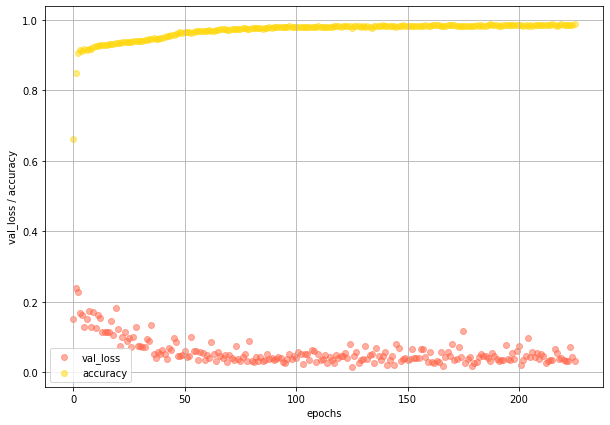

In [7]:
# 성능 평가.
# 검증 손실값(오차값)과 정확도를 그래프로 비교.
# history() : fit () 함수의 return 값으로 히스토리 객체를 얻어올 수 있음.
# 매 epoch 마다 훈련 손실값(loss), 훈련 정확도(acc), 검증 손실 값(val_loss), 검증 정확도 (val_acc)
x_len = np.arange(226)

plt.figure(figsize=(10, 7))
plt.scatter(x_len, history.history['val_loss'], label='val_loss', c='tomato', alpha=.5)
plt.scatter(x_len, history.history['accuracy'], label='accuracy', c='gold', alpha=.5)
plt.xlabel('epochs')
plt.ylabel('val_loss / accuracy')
plt.legend()
plt.grid()
plt.show()

In [8]:
# Best 모델 로딩.
best_model = load_model('models/126-0.015562995336949825.hdf5')
best_model.evaluate(x, y)[1]

204/204 [==============================] - 0s 1ms/step - loss: 0.0810 - accuracy: 0.9748


0.9747575521469116

In [9]:
# 예측 결과 추출.
pred = (best_model.predict(x) > 0.5).astype('int32')
pred

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [10]:
# 평가.
print(f'Accuracy : {round(accuracy_score(y, pred), 3)*100}%')

Accuracy : 97.5%
